# AboutDonors.org


DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.



Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve: 
* How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible
* How to increase the consistency of project vetting across different volunteers to improve the experience for teachers
* How to focus volunteer time on the applications that need the most assistance</li>
   


The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

## Understand the DonorsChoose Data Set's Attributes

There are two files:   1.train_data.csv(consists 17 features)

                2.resources.csv(consists 4 features)

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### importing all necessary modules

In [1]:
#import all necessary modules
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from tqdm import tqdm
import os

from collections import Counter

from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection  
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

## 1. Reading Data

In [3]:
#load two datafiles into the dataframe
project_data = pd.read_csv('train_data.csv')
resources_data = pd.read_csv('resources.csv')

In [4]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [5]:
#dataframe
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1


In [6]:
#dataframe
resources_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [7]:
#print number of datapoints and columns in resources_data
print('number of datapoints in resources_data:',resources_data.shape)
print("*"*60)
print('total features in resources_data:', resources_data.columns)

number of datapoints in resources_data: (1541272, 4)
************************************************************
total features in resources_data: Index(['id', 'description', 'quantity', 'price'], dtype='object')


**observation:**
* in project data we have 109248 datapoints(rows) and 17 features (columns).
* in resources_data we have 1541272 datapoints and  4 features(columns)

**'Project_is_approved'** Attribute:
* in the project_proposal_data' dataframe we have  'project is approved'  Attribute, it consists with 2 values that are [1]Number of projects approved and [0] number of projects not approved.

# 2. text preprocessing ( text data& categorical data)

**remove and replace  unwanted symbols, special charecters and words**

In [8]:
catogories = list(project_data['project_subject_categories'].values)
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
l = []  #creat empty list
for i in catogories:      #each category ex"math&Scince" in catogeries ex[["Math & Science", "Warmth", "Care & Hunger"]]
    temp = ""       #empty
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts 
        if 'The' in j.split(): # this will split each of the catogory based on space 
            j=j.replace('The','') # if we have the words "The" we are going to replace it with '' empty
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) 
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') 
    l.append(temp.strip())
# l is list with all cleaned categories.

In [9]:
project_data['clean_proj_categories'] = l    #creat new attribute and store all cleaned catogeries into that attribute, 
project_data.drop(['project_subject_categories'], axis=1, inplace=True) #remove that previous subject_catogery attribute.

### 2.2 project_grade_category

In [10]:
catogories = list(project_data['project_grade_category'].values)
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
l = []  #creat empty list
for i in catogories:      #each category ex"math&Scince" in catogeries ex[["Math & Science", "Warmth", "Care & Hunger"]]
    temp = ""       #empty
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts 
        j = j.replace(' ','_') # we are placeing all the ' '(space) with ''(empty) 
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('-','_') 
    l.append(temp.strip())
# l is list with all cleaned categories.

In [11]:
project_data['clean_proj_grade'] = l    #creat new attribute and store all cleaned catogeries into that attribute, 
project_data.drop(['project_grade_category'], axis=1, inplace=True) #remove that previous grade_catogery attribute.

### 2.3  project_subject_subcategories

In [12]:
catogories = list(project_data['project_subject_subcategories'].values)
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
lst = []  #creat empty list
for i in catogories:      #each category ex"math&Scince" in catogeries ex[["Math & Science", "Warmth", "Care & Hunger"]]
    temp = ""       #empty
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts 
        if 'The' in j.split(): # this will split each of the catogory based on space 
            j=j.replace('The','') # if we have the words "The" we are going to replace it with '' empty
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) 
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') 
    lst.append(temp.strip())
#lst is list with all cleaned subcategories.

In [13]:
project_data['clean_proj_subcategories'] = lst    #creat new attribute and store all cleaned catogeries into that attribute, 
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True) #remove that previous subject_subcatogery attribute.

## 2.4 Text Preprocessing
###  Project Essay's

there are we have 4 essays's:
   1.  project_essay_1 
   2.  project_essay_2
   3.  project_essay_3 
   4.  project_essay_4
* so we have to  merge(combilne) 4 essays into one single essay.

In [14]:
# merge all essay columns into single essay columns 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [15]:
#remove that previous project_essay_1,2,3 and 4
project_data.drop(["project_essay_1"], axis=1, inplace=True) 
project_data.drop(["project_essay_2"], axis=1, inplace=True) 
project_data.drop(["project_essay_3"], axis=1, inplace=True) 
project_data.drop(["project_essay_4"], axis=1, inplace=True) 

In [16]:
# to observe the random esssay text data
print(project_data['essay'].values[102])

Hello!, thank you for wanting to learn more about my class! My students are Deaf and Hard-of-Hearing. The ages range from 6-8 years old. They don't have a lot of the life experiences as other students do. Almost all of my class qualifies for free lunch. Some of them ride the bus for over an hour a day (one way) to get to school. I would like to make learning fun and interactive.\r\n\r\nThey don't have access to language as other students. I want my students to become engaged in their learning and be able to interact with it. I can show them pictures in a book but then I have to put the book down so I can sign the story. So they lose the visual. It isn't possible to sign and hold a book at the same time.\r\n\r\nMy classroom is special because my students require a lot of visual aids and pictures.  I would love to show them a video of a whale or show them pictures about what we are learning.This technology would benefit my students so much. They would be able to see the text or book that

**observation**
* In the above essay feature  there are lot of unnecessary  special charecters and some other  words so we have to clean text data

In [17]:
# expand contractions

# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
#english stopwords
import nltk
d = nltk.corpus.stopwords.words('english')
print(set(d))
print(len(d))


{'before', 'is', 'but', 'of', 'does', 'can', 'mustn', "wouldn't", 'll', 'no', 'weren', 'above', 'was', 'had', 'herself', 'having', 'same', 'mightn', 'by', 'd', 'couldn', "you'd", 'an', 've', 'y', 'her', 'than', "mightn't", 'other', "you'll", 'each', 'so', "mustn't", "don't", 'in', 'not', 'be', 'how', 'hadn', 'its', "that'll", 'he', 'me', 'the', 'there', "shan't", 'into', 'again', 'ma', 'needn', "won't", 'when', 'once', 'few', 'such', "doesn't", 'as', 'while', 'only', 'nor', "wasn't", 'those', 'won', 'ours', 'wasn', 'this', 'down', 'yours', 'what', 's', 'any', 'himself', 'from', 'on', "it's", 'over', 'during', 'both', 'out', 'that', 'itself', "needn't", 'these', 'haven', 'off', 'now', 'because', 'you', 'didn', 'whom', 'doesn', "hadn't", 'being', "weren't", 'why', 'here', 'which', "haven't", 'if', 'their', "you've", 'they', 'yourself', 't', 'don', 'am', "aren't", 'too', 'and', 'to', 'most', 'myself', 'i', 'has', 'our', 'just', 'have', 'or', 're', "should've", 'your', 'below', "couldn't",

#### note: we should remove some  words('no', 'nor', 'not') from stop words 

In [19]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

### 2.3.1 text preprocessing project_essay

In [20]:
#replace & remove some unneccesary words in text

from tqdm import tqdm
preproccessed_essay_text = []
# tqdm is for printing the status bar
for sent in tqdm(project_data['essay'].values):    #all text data in essay feature 
    s = decontracted(sent)                  #function calling for expand contraction words
    s = s.replace('\\r', ' ')                   #replacing \\r with space
    s = s.replace('\\"', ' ')                   #replacing \\"', with space
    s = s.replace('\\n', ' ')                   #replacing \\n with space
    s = re.sub('[^A-Za-z0-9]+', ' ', s)      #selection charecters only between Ato Z, a-z and 0-9.
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in s.split() if e not in stopwords) #removing stopwords
    preproccessed_essay_text.append(s.lower().strip())   #all sentences into lower case.

100%|██████████| 109248/109248 [00:46<00:00, 2372.08it/s]


In [21]:
project_data['preproccessed_essay_text'] = preproccessed_essay_text    #creat new attribute and store all cleanedessay text into that attribute, 
project_data.drop(['essay'], axis=1, inplace=True) #remove that previous essay attribute.

### 3.2.2 Text preprocessing project_Title

In [22]:
# to observe the some random title text data
print(project_data['project_title'].values[1])
print("*"*40)
print(project_data['project_title'].values[1200])
print("*"*40)

Wanted: Projector for Hungry Learners
****************************************
Flexible Seating! Movement + Comfort = Learning
****************************************


#### text preprocessing project_title

In [23]:
from tqdm import tqdm
preproccessed_title_text = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['project_title'].values):    #all text data in essay feature 
    s = decontracted(sentence)                  #function calling for expand contraction words
    s = re.sub('[^A-Za-z0-9]+', ' ', s)      #selection charecters only between Ato Z, a-z and 0-9.
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in s.split() if e not in stopwords) #removing stopwords
    preproccessed_title_text.append(s.lower().strip())   #all sentences into lower case.

100%|██████████| 109248/109248 [00:01<00:00, 56433.35it/s]


In [24]:
project_data['preproccessed_title_text'] = preproccessed_title_text    #creat new attribute and store all cleanedessay text into that attribute, 
project_data.drop(['project_title'], axis=1, inplace=True) #remove that previous project title attribute.

#### Text preprocessing project_resource_summary

In [25]:
from tqdm import tqdm
preproccessed_resource_text = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['project_resource_summary'].values):    #all text data in project_resource_summaryfeature 
    s = decontracted(sentence)                  #function calling for expand contraction words
    s = re.sub('[^A-Za-z0-9]+', ' ', s)      #selection charecters only between Ato Z, a-z and 0-9.
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in s.split() if e not in stopwords) #removing stopwords
    preproccessed_resource_text.append(s.lower().strip())   #all sentences into lower case.

100%|██████████| 109248/109248 [00:04<00:00, 23653.54it/s]


In [26]:
project_data['preproccessed_prjct_resource_summary'] = preproccessed_resource_text    #creat new attribute and store all cleanedessay text into that attribute, 
project_data.drop(['project_resource_summary'], axis=1, inplace=True) #remove that previous resource_text attribute.

## 2.3.4 dataframe after text preprocessed features

In [27]:
#print top 4 data points  after text preprocessed features
project_data.head(4)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,teacher_number_of_previously_posted_projects,project_is_approved,clean_proj_categories,clean_proj_grade,clean_proj_subcategories,preproccessed_essay_text,preproccessed_title_text,preproccessed_prjct_resource_summary
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,0,0,Literacy_Language,Grades_PreK_2,ESL Literacy,my students are english learners that are work...,educational support for english learners at home,my students need opportunities to practice beg...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,7,1,History_Civics Health_Sports,Grades_6_8,Civics_Government TeamSports,our students arrive to our school eager to lea...,wanted projector for hungry learners,my students need a projector to help with view...
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,1,0,Health_Sports,Grades_6_8,Health_Wellness TeamSports,true champions are not always the ones that wi...,soccer equipment for awesome middle school stu...,my students need shine guards athletic socks s...
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,4,1,Literacy_Language Math_Science,Grades_PreK_2,Literacy Mathematics,i work at a unique school filled with both esl...,techie kindergarteners,my students need to engage in reading and math...


## 2.4 Join two dataframe(project_proposal_data and resources_data) based on ID

In [28]:
#to get price of the project
resources_data.head(3)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45


In [29]:
#https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
#from resources data  coulumns group by id and sum values of two columns
price_data = resources_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(3)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4


In [30]:
#join(merge) two data frames based on id
project_data = pd.merge(project_data, price_data, on='id', how='left')  #how=lef if any remaining data present in any df that will be merge with dataframe


In [31]:
#shape of the final merged dataframe
project_data.shape

(109248, 16)

we have 109248 datapoints and 16 features

## print final data frame

In [32]:
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,teacher_number_of_previously_posted_projects,project_is_approved,clean_proj_categories,clean_proj_grade,clean_proj_subcategories,preproccessed_essay_text,preproccessed_title_text,preproccessed_prjct_resource_summary,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,0,0,Literacy_Language,Grades_PreK_2,ESL Literacy,my students are english learners that are work...,educational support for english learners at home,my students need opportunities to practice beg...,154.60,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,7,1,History_Civics Health_Sports,Grades_6_8,Civics_Government TeamSports,our students arrive to our school eager to lea...,wanted projector for hungry learners,my students need a projector to help with view...,299.00,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,1,0,Health_Sports,Grades_6_8,Health_Wellness TeamSports,true champions are not always the ones that wi...,soccer equipment for awesome middle school stu...,my students need shine guards athletic socks s...,516.85,22


## 2.5.1 (identify) select the class lable 

according to the above dataframe 
**'Project_is_approved'** Attribute:
* in the project_data' dataframe we have  'project is approved'  Attribute, it consists with 2 values that are [1]Number of projects approved and [0] number of projects not approved.

In [33]:
#y is class label
y = project_data['project_is_approved'].values       #storing all project_is approved attribute values in y variable
project_data.drop(['project_is_approved'], axis=1, inplace=True)    #eliminate the project_is_approved attribute from dataframe


# 2.6 Splitting data

### split data into train, cross validation and test data

In [34]:
# splitting into train, crossvalidation and test data
from sklearn.model_selection import train_test_split

# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(project_data, y, test_size=0.33, stratify=y)  # split 33% data in test data and  67% in train data
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)  #split train data into train and cross_valiadation

our total dataset splitted into train data, cross validation data and test data.

In [35]:
#print shape of splitted data
print("data before feature vectorizing:")
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

data before feature vectorizing:
(49041, 15) (49041,)
(24155, 15) (24155,)
(36052, 15) (36052,)


**observation**
* there are 22445 datapoints in train data.
* 11055 datapoints in cross validation data.
* 16500 datapoints in test data.

# 2.7 Creating Data Matrix

# 2.8 feature vectorization (BOW)

## 2.8.1 converting the preproccessed_essay_text to vectors(bag of words)

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
# We are considering only the words which appeared in at least 10 documents(rows or projects).
#ngram_range=(1,2) selecting unigrams and bigrams
vectorizer1 = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000) #select maximum vectorized features = 5000
vectorizer1.fit(X_train['preproccessed_essay_text'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
# applying  learned parameters (vocabulary) to the train, cv and cross validation
X_train_essay_bow = vectorizer1.transform(X_train['preproccessed_essay_text'].values)
X_cv_essay_bow = vectorizer1.transform(X_cv['preproccessed_essay_text'].values)
X_test_essay_bow = vectorizer1.transform(X_test['preproccessed_essay_text'].values)

print("*"*60)
print("After vectorizations:")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)


************************************************************
After vectorizations:
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


* after BOW vecterization we have X_train data 49041 data points with 5000 features
* in x_cv 24155 datapoints, 5000features
* in x_test 36052 datapoints, and 5000 features

## 2.8.2 converting the preproccessed_title_text to vectors(bag of words)

In [37]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
#ngram_range=(1,2) selecting unigrams and bigrams
vectorizer1 = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000) #select maximum vectorized features = 5000
vectorizer1.fit(X_train['preproccessed_title_text'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
# applying  learned parameters (vocabulary) to the train, cv and cross validation
X_train_title_bow = vectorizer1.transform(X_train['preproccessed_title_text'].values)
X_cv_title_bow = vectorizer1.transform(X_cv['preproccessed_title_text'].values)
X_test_title_bow = vectorizer1.transform(X_test['preproccessed_title_text'].values)

print("*"*60)
print("After vectorizations:")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)


************************************************************
After vectorizations:
(49041, 4754) (49041,)
(24155, 4754) (24155,)
(36052, 4754) (36052,)


# 2.9 feature vectorization (TFIDF)

## 2.9.1 converting the preproccessed_essay_text to vectors(TFIDF)

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
#ngram_range=(1,2) selecting unigrams and bigrams
vectorizer2 = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)#select maximum vectorized features = 5000
vectorizer2.fit(X_train['preproccessed_essay_text'].values)
# applying  learned parameters (vocabulary) to the train, cv and cross validation
X_train_essay_tfidf = vectorizer2.transform(X_train['preproccessed_essay_text'].values)
X_cv_essay_tfidf = vectorizer2.transform(X_cv['preproccessed_essay_text'].values)
X_test_essay_tfidf = vectorizer2.transform(X_test['preproccessed_essay_text'].values)

print("*"*60)
print("After vectorizations:")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

************************************************************
After vectorizations:
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


## 2.9.2 converting the preproccessed_title_text to vectors(TFIDF)

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
#ngram_range=(1,2) selecting unigrams and bigrams
vectorizer2 = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)#select maximum vectorized features = 5000
vectorizer2.fit(X_train['preproccessed_title_text'].values)
# applying  learned parameters (vocabulary) to the train, cv and cross validation
X_train_title_tfidf = vectorizer2.transform(X_train['preproccessed_title_text'].values)
X_cv_title_tfidf = vectorizer2.transform(X_cv['preproccessed_title_text'].values)
X_test_title_tfidf = vectorizer2.transform(X_test['preproccessed_title_text'].values)

print("*"*60)
print("After vectorizations:")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)

************************************************************
After vectorizations:
(49041, 4754) (49041,)
(24155, 4754) (24155,)
(36052, 4754) (36052,)


# 2.10 feature vectorization (AVGW2V)

## 1. Training W2V model

In [41]:
#import word2vec 
from gensim.models import Word2Vec   #to make own w2vec model
from gensim.models import KeyedVectors   #w2v model by googlenews-300.bin
from tqdm import tqdm
import numpy as np

#### 1.1 Preparing list of list with sentences for model

In [42]:
i = 0
list_of_sentance_train=[]  #empty list 
for sentance in X_train['preproccessed_essay_text'].values:  #for ecah sentence(text) in  essay text train data
    list_of_sentance_train.append(sentance.split())   #append in list (list of lists with   sentences)

### 1.2 train Word2Vec on train data(list of sentences)

In [43]:
# train w2v model on  list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=6,size=50, workers=4)
#list of sentence [['w1'],['w2']....] in train essay data, min_count = 6 if word  atleast 6times occure then it will be consider
#size = 50 w-->vec dimensions, workers=4  multicore of computer(laptop)

In [44]:
w2v_words = list(w2v_model.wv.vocab)     #model trained vocubulary words
print("all words occured minimum 4 times ",len(w2v_words))
print("sample_w2v_ words ", w2v_words[0:60])   #print 40 words

all words occured minimum 4 times  15883
sample_w2v_ words  ['what', 'makes', 'our', 'school', 'special', 'is', 'that', 'students', 'come', 'to', 'small', 'but', 'mighty', 'beach', 'side', 'elementary', 'from', 'various', 'backgrounds', 'and', 'lifestyles', 'located', 'in', 'a', 'cozy', 'town', 'proud', 'dedicated', 'educate', 'of', 'military', 'families', 'who', 'serve', 'variety', 'local', 'foreign', 'capacities', 'out', 'patrick', 'air', 'force', 'base', 'community', 'are', 'eager', 'learn', 'enhance', 'through', 'their', 'curiosity', 'life', 'experiences', 'need', 'be', 'exposed', 'genres', 'text', 'have', 'the']


total words 11639 wich are occured atleast 4 times in model trained vocubulary words

## 2.10.1 converting the preproccessed_essay_text to vectors(AVGW2V)

##  I. Converting Train data  essay text to AVGW2V

In [45]:
# average Word2Vec
# compute average word2vec for each datapoint in essay_train data.
X_train_essay_avgw2v = [] 
for sent in tqdm(list_of_sentance_train): # for each sentence in list_of_sentance_train
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_essay_avgw2v.append(sent_vec)
X_train_essay_avgw2v = np.array(X_train_essay_avgw2v)  #converting all essay word2vec words into array
print(X_train_essay_avgw2v.shape)
print(X_train_essay_avgw2v[2])

100%|██████████| 49041/49041 [03:21<00:00, 243.41it/s]


(49041, 50)
[-0.08286444 -0.0450041   0.50364094  0.00775188  0.70011935 -0.14898868
  0.19211961  0.4642734  -0.57970895  0.70365948 -0.32028422 -0.02196164
  0.24481321 -0.23465015 -0.44345859 -0.17344241 -0.22475705  0.41182661
  0.17504492 -0.4495221  -0.03491888 -0.75411391  0.1582986   0.1517306
 -0.26574535  0.81997773  0.48296056  0.15843937 -0.05547971 -0.44052037
 -0.38788896 -0.65990184  0.11544042  0.52259315 -0.69604276 -0.45766091
 -0.03422475 -0.21842371  0.62743192  0.54753636  1.02138316  0.06615968
 -0.42191661  0.30668597  0.26523843 -0.73302307  0.75865591  0.44633123
 -0.11219384  0.4192298 ]


## II. Converting Cross_Validation  essay data text to AVGW2V

In [46]:
i = 0
list_of_sentance_cv=[]  #empty list 
for sentance in X_cv['preproccessed_essay_text'].values:  #for ecah sentence(text)  in  essay text cv data
    list_of_sentance_cv.append(sentance.split())   #append in list (list of lists with   sentences)

In [47]:
# average Word2Vec
# compute average word2vec for each datapoint in cv data.
X_cv_essay_avgw2v = [] 
for sent in tqdm(list_of_sentance_cv): # for each sentence in list_of_sentance_train
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_essay_avgw2v.append(sent_vec)
X_cv_essay_avgw2v = np.array(X_cv_essay_avgw2v)  #converting all essay word2vec words into array
print(X_cv_essay_avgw2v.shape)
print(X_cv_essay_avgw2v[2])

100%|██████████| 24155/24155 [01:38<00:00, 245.26it/s]


(24155, 50)
[ 0.04610416 -0.494956    0.31534768  0.12603013  1.02267684 -0.41155276
  0.39596894  0.7887731  -0.95443082  1.09318542 -0.39098625 -0.00514927
  0.50360448  0.28251484 -0.70105604  0.13227801  0.13368605  0.89654666
  0.22243087 -0.88755082  0.08363654 -1.13730788  0.47685349  0.54163455
  0.03743278  0.72496501  0.42079892 -0.47837062  0.30960976 -0.41224596
 -0.32124507 -1.29391913  0.26114692  0.2896432  -0.68241085  0.00610199
 -0.12276574  0.4724119   1.37078758  0.42330044  1.17203574 -0.41031791
 -0.39372052  0.82288921  0.60973463 -1.06256766  0.88570547  0.75184129
  0.21191249  0.37104189]


## III. Converting Test  essay data text to AVGW2V

In [48]:
i = 0
list_of_sentance_test=[]  #empty list 
for sentance in X_test['preproccessed_essay_text'].values:  #for ecah sentence(text)  in  essay text cv data
    list_of_sentance_test.append(sentance.split())   #append in list (list of lists with   sentences)

In [49]:
# average Word2Vec
# compute average word2vec for each datapoint in essay_test data.
X_test_essay_avgw2v = [] 
for sent in tqdm(list_of_sentance_test): # for each sentence in list_of_sentance_train
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_essay_avgw2v.append(sent_vec)
X_test_essay_avgw2v = np.array(X_test_essay_avgw2v)  #converting all essay word2vec words into array
print(X_test_essay_avgw2v.shape)
print(X_test_essay_avgw2v[2])

100%|██████████| 36052/36052 [02:28<00:00, 243.19it/s]


(36052, 50)
[-0.04201302 -0.49232123  0.47481936 -0.03347628  0.51663534  0.29149929
  0.00940082  0.25629552 -0.30127519  0.63400559 -0.23326843 -0.20410957
  0.43551831 -0.51993241 -0.81010755  0.07998317 -0.05551669  0.70785259
  0.22721734 -0.07497568  0.02801823 -0.79635661  0.34054965 -0.24862933
 -0.21780369  1.03565189  0.10809483 -0.29281811 -0.11415421 -0.42994529
  0.45850389 -0.99712787  0.58279657  0.26110718 -0.84944771 -0.36254336
 -0.44411531  0.13577172  0.89263665  0.37233686  0.77923365  0.70212833
  0.44029998  0.8009603   0.30482429 -0.55041444  0.62858837  0.94975148
  0.10815218  0.41580914]


## 2.10.2 converting the preproccessed_title_text to vectors(AVGW2V)

### 1. Training W2V model

#### 1.1 Preparing list of list with sentences for model

In [50]:
i = 0
list_of_sentance_train=[]  #empty list 
for sentance in X_train['preproccessed_title_text'].values:  #for ecah sentence(text) in  title text train data
    list_of_sentance_train.append(sentance.split())   #append in list (list of lists with   sentences)

### 1.2 train Word2Vec on train data(list of sentences)

In [51]:
# train w2v model on  list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=6,size=50, workers=4)
#list of sentence [['w1'],['w2']....] in train essay data, min_count = 4 if word  atleast 4 times occure then it will be consider
#size = 50 w-->vec dimensions, workers=4  multicore of computer(laptop)

In [52]:
w2v_words = list(w2v_model.wv.vocab)     #model trained vocubulary words
print("all words occured minimum 6 times ",len(w2v_words))
print("sample_w2v_ words ", w2v_words[0:60])   #print 40 words

all words occured minimum 6 times  2967
sample_w2v_ words  ['building', 'a', 'classroom', 'library', 'full', 's', 't', 'e', 'm', 'ahead', 'with', 'technology', 'roll', 'away', 'not', 'these', 'pencils', 'economic', 'way', 'of', 'thinking', 'targeting', 'our', 'health', 'wiggles', 'and', 'hokki', 'pokey', 'staying', 'active', 'focused', 'forever', 'fabulous', 'in', 'fifth', 'for', 'the', 'love', 'reading', 'action', 'family', 'sensory', 'exploration', 'content', 'tech', 'graphic', 'is', 'seat', 'everyone', 'let', 'organize', 'we', 'need', 'some', 'magic', 'carpet', 'ride', 'to', 'community', 'steaming']


## I. Converting  title Train data  text to AVGW2V

In [53]:
# average Word2Vec
# compute average word2vec for each datapoint in title_train data.
X_train_title_avgw2v = [] 
for sent in tqdm(list_of_sentance_train): # for each sentence in list_of_sentance_train
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_title_avgw2v.append(sent_vec)
X_train_title_avgw2v = np.array(X_train_title_avgw2v)  #converting all title word2vec words into array
print(X_train_title_avgw2v.shape)


100%|██████████| 49041/49041 [00:03<00:00, 14628.19it/s]

(49041, 50)


## II. Converting Title Cross_Validation   data text to AVGW2V

In [54]:
i = 0
list_of_sentance_cv=[]  #empty list 
for sentance in X_cv['preproccessed_title_text'].values:  #for ecah sentence(text)  in  title text cv data
    list_of_sentance_cv.append(sentance.split())   #append in list (list of lists with   sentences)

In [55]:
# average Word2Vec
# compute average word2vec for each datapoint in cv data.
X_cv_title_avgw2v = [] 
for sent in tqdm(list_of_sentance_cv): # for each sentence in list_of_sentance_cv
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_title_avgw2v.append(sent_vec)
X_cv_title_avgw2v = np.array(X_cv_title_avgw2v)  #converting all title word2vec words into array
print(X_cv_title_avgw2v.shape)
print(X_cv_title_avgw2v[3])

100%|██████████| 24155/24155 [00:01<00:00, 14145.09it/s]


(24155, 50)
[-0.085651    0.48037555  0.93637433  0.78690943  0.05452941 -0.41390377
  0.08784159 -1.01091451 -0.65248191 -0.19770095  0.75393316  0.71308711
 -0.50418759  0.21794194  0.45608385  0.09460253 -0.26151399  0.30779707
 -0.28727982 -0.13680041  0.8623657  -0.28943141 -0.45335941  0.44244724
  0.35484517 -0.13817661  0.15693307  0.39352671  0.53184451  0.45502158
  0.59979262 -0.16950581 -0.32978588 -0.44837066 -0.3071218   0.89328251
 -0.50130863  0.31892762 -0.59398844 -0.08179233 -0.60107292  0.36433881
  0.5135904  -0.38649226 -0.06767107  0.38266583  0.11337695 -0.49850628
 -0.24068761  0.32570582]


## III. Converting  Title Test data text to AVGW2V

In [56]:
# average Word2Vec
# compute average word2vec for each datapoint in title_test data.
X_test_title_avgw2v = [] 
for sent in tqdm(list_of_sentance_test): # for each sentence in list_of_sentance_test
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_title_avgw2v.append(sent_vec)
X_test_title_avgw2v = np.array(X_test_title_avgw2v)  #converting all title word2vec words into array
print(X_test_title_avgw2v.shape)
print(X_test_title_avgw2v[2])

100%|██████████| 36052/36052 [02:07<00:00, 283.07it/s]


(36052, 50)
[ 0.25769291  0.50823366  0.38925483 -0.13090123 -0.50253594 -0.00979596
  0.06598286 -0.55185558  0.36496269 -0.11823639  0.40482885  0.21275339
 -0.11027965 -0.28987173  0.16399286 -0.42348     0.1799228  -0.07070518
 -0.54348126  0.10490654  0.51843419  0.42987119 -0.21524216 -0.48409865
  0.08233288 -0.14590597 -0.15307234  0.5142459  -0.30572356  0.53059589
  0.09535735  0.14224703 -0.33553662 -0.10500297  0.21168231  0.1904492
  0.16255162  0.10361804 -0.37938437  0.01685797 -0.18788902  0.83002272
  0.24534115 -0.37391637 -0.23472384  0.51324047 -0.08378335  0.15298079
  0.01013444  0.22743492]


# 2.11 feature vectorization (TFIDF-W2V)

## 2.11.1  Converting  Essay  data  text to TFIDF-W2V

### 1. Training W2V model on train data

In [57]:
# Preparing list of list with sentences for model
#train Word2Vec on train data(list of sentences)
i = 0
list_of_sentance_train=[]  #empty list 
for sentance in X_train['preproccessed_essay_text'].values:  #for ecah sentence(text) in  essay text train data
    list_of_sentance_train.append(sentance.split())   #append in list (list of lists with   sentences)

#train Word2Vec on train data(list of sentences)
w2v_model=Word2Vec(list_of_sentance_train,min_count=6,size=50, workers=4)

### 2. Training tfidf model on train data

In [58]:
#tfidf model
tfidf_model = TfidfVectorizer(min_df=10,ngram_range=(1,3), max_features=5000)#select maximum vectorized features = 5000
tfidf_model.fit(X_train['preproccessed_essay_text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

## I. Converting  Essay Train data  text to TFIDF-W2V

In [59]:
# average Word2Vec
# compute average word2vec for each sentence.
X_train_essay_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_train['preproccessed_essay_text'].values): # for each sentence in train essaty data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_essay_tfidfw2v.append(vector)

print(len(X_train_essay_tfidfw2v))
print(len(X_train_essay_tfidfw2v[0]))

100%|██████████| 49041/49041 [04:49<00:00, 169.24it/s]

49041
50


## II. Converting  Essay CV data  text to TFIDF-W2V

#### word2vec model and tfidf model already fit on train data

In [60]:
# average Word2Vec
# compute average word2vec for each sentence.
X_cv_essay_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_cv['preproccessed_essay_text'].values): # for each sentence in cv essaty data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_cv_essay_tfidfw2v.append(vector)

print(len(X_cv_essay_tfidfw2v))
print(len(X_cv_essay_tfidfw2v[0]))

100%|██████████| 24155/24155 [02:21<00:00, 170.52it/s]

24155
50


## III. Converting  Essay TEST data  text to TFIDF-W2V

In [61]:
# average Word2Vec
# compute average word2vec for each sentence.
X_test_essay_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_test['preproccessed_essay_text'].values): # for each sentence in test essaty data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_essay_tfidfw2v.append(vector)

print(len(X_test_essay_tfidfw2v))
print(len(X_test_essay_tfidfw2v[0]))

100%|██████████| 36052/36052 [03:43<00:00, 161.44it/s]

36052
50


## 2.11.2 Converting  Tile  data  text to TFIDF-W2V

### 1. Training W2V model on train data

In [62]:
# Preparing list of list with sentences for model
#train Word2Vec on title train data(list of sentences)
i = 0
list_of_sentance_train=[]  #empty list 
for sentance in X_train['preproccessed_title_text'].values:  #for ecah sentence(text) in  essay title train data
    list_of_sentance_train.append(sentance.split())   #append in list (list of lists with   sentences)

#train Word2Vec on title train data(list of sentences)
w2v_model=Word2Vec(list_of_sentance_train,min_count=6,size=50, workers=4)

### 2. Training tfidf model on train data

In [63]:
#tfidf model
tfidf_model = TfidfVectorizer(min_df=10,ngram_range=(1,3), max_features=5000)#select maximum vectorized features = 5000
tfidf_model.fit(X_train['preproccessed_title_text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

## I. Converting  title Train data  text to TFIDF-W2V

In [64]:
# average Word2Vec
# compute average word2vec for each sentence.
X_train_title_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_train['preproccessed_title_text'].values): # for each sentence in train title data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_title_tfidfw2v.append(vector)

print(len(X_train_title_tfidfw2v))
print(len(X_train_title_tfidfw2v[0]))

100%|██████████| 49041/49041 [00:03<00:00, 12574.29it/s]

49041
50


## II. Converting  title CV data  text to TFIDF-W2V

In [65]:
# average Word2Vec
# compute average word2vec for each sentence.
X_cv_title_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_cv['preproccessed_title_text'].values): # for each sentence in cv title data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_cv_title_tfidfw2v.append(vector)

print(len(X_cv_title_tfidfw2v))
print(len(X_cv_title_tfidfw2v[0]))

100%|██████████| 24155/24155 [00:01<00:00, 12849.71it/s]

24155
50


## III. Converting  Title TEST data  text to TFIDF-W2V

In [66]:
# average Word2Vec
# compute average word2vec for each sentence.
X_test_title_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_test['preproccessed_title_text'].values): # for each sentence in test title data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_title_tfidfw2v.append(vector)

print(len(X_test_title_tfidfw2v))
print(len(X_test_title_tfidfw2v[0]))

100%|██████████| 36052/36052 [00:02<00:00, 12377.95it/s]

36052
50


# 3.0  One-Hot-Encoding Categorical features

**there are 5 categorical features:**
* school state
* clean project subject category
* clean project subject sub category
* project_grade
* teacher prefix


## 3.1 one-hot-encode( schoolstate)

In [67]:
#onehotencoding
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # countvectorizer fit on only train data

#then fitted countvectorizer afflys on train,test and cv data
X_train_state_onehot = vectorizer.transform(X_train['school_state'].values)  #learned vocubulary vectorizer applies on train data
X_cv_state_onehot = vectorizer.transform(X_cv['school_state'].values)        #learned vocubulary vectorizer applies on cv data
X_test_state_onehot = vectorizer.transform(X_test['school_state'].values)    #learned vocubulary vectorizer applies on test data

print("*"*60)
print("After  one hot encode vectorizations")
print(X_train_state_onehot.shape, y_train.shape)
print(X_cv_state_onehot.shape, y_cv.shape)
print(X_test_state_onehot.shape, y_test.shape)

************************************************************
After  one hot encode vectorizations
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)


## 3.2 one-hot-encode (clean_proj_categories)

In [68]:
#onehotencoding
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_proj_categories'].values) # countvectorizer fit on only train data

#then fitted countvectorizer afflys on train,test and cv data
#learned vocubulary vectorizer applies on train data
X_train_proj_categories_onehot = vectorizer.transform(X_train['clean_proj_categories'].values)  
X_cv_proj_categories_onehot = vectorizer.transform(X_cv['clean_proj_categories'].values)        
X_test_proj_categories_onehot = vectorizer.transform(X_test['clean_proj_categories'].values)  

print("*"*60)
print("After  one hot encode vectorizations")
print(X_train_proj_categories_onehot.shape, y_train.shape)
print(X_cv_proj_categories_onehot.shape, y_cv.shape)
print(X_test_proj_categories_onehot.shape, y_test.shape)

************************************************************
After  one hot encode vectorizations
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)


## 3.3 one-hot-encode (clean_proj_subcategories)

In [69]:
#onehotencoding
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_proj_subcategories'].values) # countvectorizer fit on only train data

#then fitted countvectorizer afflys on train,test and cv data
#learned vocubulary vectorizer applies on train data
X_train_proj_subcategories_onehot = vectorizer.transform(X_train['clean_proj_subcategories'].values)  
X_cv_proj_subcategories_onehot = vectorizer.transform(X_cv['clean_proj_subcategories'].values)        
X_test_proj_subcategories_onehot = vectorizer.transform(X_test['clean_proj_subcategories'].values)  

print("*"*60)
print("After  one hot encode vectorizations")
print(X_train_proj_subcategories_onehot.shape, y_train.shape)
print(X_cv_proj_subcategories_onehot.shape, y_cv.shape)
print(X_test_proj_subcategories_onehot.shape, y_test.shape)

************************************************************
After  one hot encode vectorizations
(49041, 30) (49041,)
(24155, 30) (24155,)
(36052, 30) (36052,)


## 3.4 one-hot-encode (clean_proj_grade)

In [70]:
#onehotencoding
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_proj_grade'].values) # countvectorizer fit on only train data

#then fitted countvectorizer afflys on train,test and cv data
#learned vocubulary vectorizer applies on train data
X_train_proj_grade_onehot = vectorizer.transform(X_train['clean_proj_grade'].values)  
X_cv_proj_grade_onehot = vectorizer.transform(X_cv['clean_proj_grade'].values)        
X_test_proj_grade_onehot = vectorizer.transform(X_test['clean_proj_grade'].values)  

print("*"*60)
print("After  one hot encode vectorizations")
print(X_train_proj_grade_onehot.shape, y_train.shape)
print(X_cv_proj_grade_onehot.shape, y_cv.shape)
print(X_test_proj_grade_onehot.shape, y_test.shape)
print(vectorizer.get_feature_names())

************************************************************
After  one hot encode vectorizations
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


## 3.5 one-hot-encode (teacher_prefix)

In [71]:
#onehotencoding
#  np.nan is an invalid document, expected byte or unicode string.   https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values.astype('U')) # countvectorizer fit on only train data

#then fitted countvectorizer afflys on train,test and cv data
#learned vocubulary vectorizer applies on train data
X_train_teacher_prefix_onehot = vectorizer.transform(X_train['teacher_prefix'].values.astype('U'))  
X_cv_teacher_prefix_onehot = vectorizer.transform(X_cv['teacher_prefix'].values.astype('U'))        
X_test_teacher_prefix_onehot = vectorizer.transform(X_test['teacher_prefix'].values.astype('U'))
print("*"*60)
print("After  one hot encode vectorizations")
print(X_train_teacher_prefix_onehot.shape, y_train.shape)
print(X_cv_teacher_prefix_onehot.shape, y_cv.shape)
print(X_test_teacher_prefix_onehot.shape, y_test.shape)
print(vectorizer.get_feature_names())

************************************************************
After  one hot encode vectorizations
(49041, 6) (49041,)
(24155, 6) (24155,)
(36052, 6) (36052,)
['dr', 'mr', 'mrs', 'ms', 'nan', 'teacher']


# 4.0  Normalizing Numerical features

**there are 3 numerical features:**
* teacher_number_of_previously_posted_projects
* price
* quantity

## 4.1  Normalizing (teacher_number_of_previously_posted_projects)

In [72]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
#normalizer applying on train teacher_number_of_previously_posted_projects data
# normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].value raises error so we need to do reshape with(-1,1)
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

#normalizer applied on train data then transfer to cv and test data
X_train_prvs_posted_prjcts_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_prvs_posted_prjcts_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_prvs_posted_prjcts_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("*"*60)
print("After vectorizations")
print(X_train_prvs_posted_prjcts_norm.shape, y_train.shape)
print(X_cv_prvs_posted_prjcts_norm.shape, y_cv.shape)
print(X_test_prvs_posted_prjcts_norm.shape, y_test.shape)

************************************************************
After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


## 4.2  Normalizing (price)

In [73]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
#normalizer applying on train price data
# normalizer.fit(X_train['price'].value raises error so we need to do reshape with(-1,1)
normalizer.fit(X_train['price'].values.reshape(-1,1))

#normalizer applied on train data then transfer to cv and test data
X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("*"*60)
print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

************************************************************
After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


## 4.3  Normalizing (quantity)

In [74]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
#normalizer applying on train quantity data
# normalizer.fit(X_train['quantity'].value raises error so we need to do reshape with(-1,1)
normalizer.fit(X_train['quantity'].values.reshape(-1,1))

#normalizer applied on train data then transfer to cv and test data
X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
X_cv_quantity_norm = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("*"*60)
print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_cv_quantity_norm.shape, y_cv.shape)
print(X_test_quantity_norm.shape, y_test.shape)

************************************************************
After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


# 5.Creating (SET1):
# <font color='green'> data matix with all categorical, all numerical,essay(BOW) and title(BOW)</font>

In [75]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#concatinating features
from scipy.sparse import hstack
X_tra = hstack((X_train_essay_bow,X_train_title_bow, X_train_state_onehot, X_train_teacher_prefix_onehot, X_train_proj_grade_onehot, X_train_proj_categories_onehot, X_train_proj_subcategories_onehot,X_train_prvs_posted_prjcts_norm, X_train_price_norm,X_train_quantity_norm )).tocsr()
X_crv = hstack((X_cv_essay_bow,X_cv_title_bow,   X_cv_state_onehot, X_cv_teacher_prefix_onehot,  X_cv_proj_grade_onehot, X_cv_proj_categories_onehot ,  X_cv_proj_subcategories_onehot,  X_cv_prvs_posted_prjcts_norm , X_cv_price_norm, X_cv_quantity_norm )).tocsr()
X_tes = hstack((X_test_essay_bow,X_test_title_bow, X_test_state_onehot, X_test_teacher_prefix_onehot,X_test_proj_grade_onehot, X_test_proj_categories_onehot,X_test_proj_subcategories_onehot, X_test_prvs_posted_prjcts_norm, X_test_price_norm,X_test_quantity_norm  )).tocsr()

print("*"*60)
print("Final set1 Data matrix:")
print(X_tra.shape, y_train.shape)
print(X_crv.shape, y_cv.shape)
print(X_tes.shape, y_test.shape)


************************************************************
Final set1 Data matrix:
(49041, 9857) (49041,)
(24155, 9857) (24155,)
(36052, 9857) (36052,)


## <font color='red'>Appling Logistic Regression on SET1</font>

**standardization of train,cv and test data**

In [76]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

#standardization train data
strd = StandardScaler(with_mean=False)
strd.fit(X_tra)

strd_bowtrain_data = strd.transform(X_tra)
print(strd_bowtrain_data.shape)
#standardization crosas validationdata
strd_bowcrv_data =strd.transform(X_crv)
print(strd_bowcrv_data.shape)
#standardization test data
strd_bowtest_data=strd.transform(X_tes)
print(strd_bowtest_data.shape)

(49041, 9857)
(24155, 9857)
(36052, 9857)


## best parameter tuning using Grid search technique

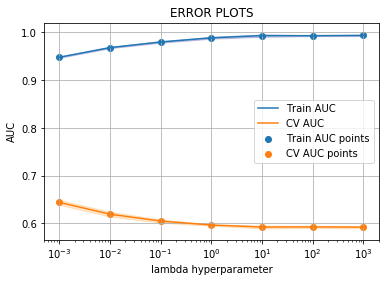

In [80]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from math import log

#logistic regression classifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
classifier =  LogisticRegression(penalty ='l2', class_weight= 'balanced', max_iter=100)  #selecting l2 regulerization

#tuned parameters taking lambda1: 'lambda' = 1/cestimator is logistic regression
gridsrch_parameters = [{'C': [10**-3, 10**-2,10**-1, 10**0,10**1,10**2, 10**3]}]
gridsrch_parameters1  = [i  for i in gridsrch_parameters[0]['C']]   #(tuned parameters) : easy to read on x axis

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grdsrch = GridSearchCV(classifier,gridsrch_parameters, scoring = 'roc_auc', cv=3, return_train_score=True)    #estimator is logistic regression
grdsrch.fit(strd_bowtrain_data, y_train)         #grid search cv applying  on  standerdized train data

train_auc= grdsrch.cv_results_['mean_train_score']
train_auc_std=grdsrch.cv_results_['std_train_score']
cv_auc = grdsrch.cv_results_['mean_test_score'] 
cv_auc_std= grdsrch.cv_results_['std_test_score']

plt.plot(gridsrch_parameters1, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(gridsrch_parameters1,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(gridsrch_parameters1, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(gridsrch_parameters1,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(gridsrch_parameters1, train_auc, label='Train AUC points')
plt.scatter(gridsrch_parameters1, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("lambda hyperparameter")
plt.xscale('log')
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

**observation**
* in above logistic regression we have used l2 regulerization.
* accordung to the above plot train auc and underfit when 'C': lambda value increses
* we can choose best 'C' value as 1.

**finding best hyper parameter by using model.best_estimator**

In [105]:
#tuned parameters taking lambda1: 'lambda' = 1/estimator is logistic regression
gridsrch_parameters = [{'C': [10**-3, 10**-2,10**-1, 10**0,10**1,10**2, 10**3]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty ='l2',class_weight= 'balanced'), gridsrch_parameters, scoring = 'f1', cv=3)
model.fit(strd_bowtrain_data, y_train)

print(model.best_estimator_)
print(model.score(strd_bowtest_data, y_test))

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.803783008341746


**observation according to the above plot**
* we can choose best c value 1

**observation according to model best esimation**
* best C  value = 1 and model f-1 score is 80 percentage 

In [121]:
#according to the above for auc plot result result we can choose 0.001 is our best 'C' as hyper parameter

best_c = 1

### Now we can observe how our  best'c' hyper  parameter value perform on Train AUROC and Test AUROC curves

In [83]:
#funtion for predict probablity score
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points

    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

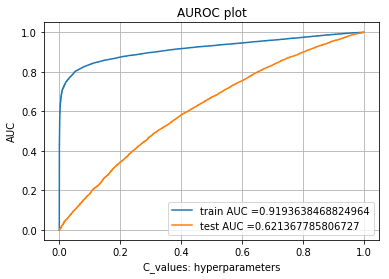

In [120]:
classifier = LogisticRegression(penalty='l2',C=1,class_weight= 'balanced')   ## c = 0.001 our selected  best hyper prameter value 
classifier.fit(strd_bowtrain_data, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates  positive class

y_train_pred = batch_predict(classifier,strd_bowtrain_data)    
y_test_pred = batch_predict(classifier, strd_bowtest_data)

#each  thresold (tow) caluculate the (train_fpr = false positive rate) and  (tpr = tru positive rate)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred) #threshoulds on probablity score of train data class label
test_fpr, test_tpr, ts_thresholds = roc_curve(y_test, y_test_pred)#threshoulds on probablity score of test data class label

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))  #plot train auc  based on each threshold train tpr and train fpr
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))  #plot train auc  based on each threshold train tpr and train fpr
plt.xlabel("C_values: hyperparameters")
plt.ylabel("AUC")
plt.title("AUROC plot")
plt.grid()
plt.legend()
plt.show()

### observation:
1. train auc and test auc both are above to the ideal roc curve.
2. AUC(performence metric) on train data = 0.91 and AUC on test data = 0.62


### <font color='purple'>Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

In [85]:
#  function to   predict thresould value which has high tpr and low fpr values: notebooks/Assignment_SAMPLE_SOLUTION.ipynb
# select the threshold that can choose the  least false positive rating
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train data confusion matrix
the maximum value of tpr*(1-fpr) 0.7091680017722379 for threshold 0.515
Confusion Matrix:
 [[ 6692   734]
 [ 8866 32749]]
****************************************
Test data confusion matrix
the maximum value of tpr*(1-fpr) 0.37532397932072226 for threshold 0.637
Confusion Matrix:
 [[ 3254  2205]
 [11330 19263]]


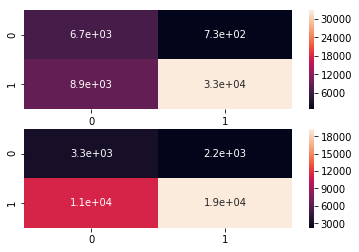

In [101]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html
import matplotlib.pyplot as plt

fig=plt.figure(1)
a = fig.add_subplot(211)
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
a = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True)    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test,predict(y_test_pred, ts_thresholds, test_fpr, test_tpr))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True)    #annot = True rectanguler dataset

**observation:**
* in above figure 1 we have 2 sub plots 1st subplot implies train data sonfusion matrix, 2 subplot implies test data confusion matrix
* in train confusion matrix we have  32749 true positive values, 8866 fpr values,6692 tnr values,734 fnr values 
* in test confusion matrix we have  19263 true positive values,11330 fpr values,  3254 tnr values,2205 fnr values 

# 6.Creating (SET2):
# <font color='green'> data matix with all categorical, all numerical,essay(TFIDF) and title(TFIDF)</font>

In [102]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#concatinating features
from scipy.sparse import hstack
X_tr1 = hstack((X_train_essay_tfidf,X_train_title_tfidf, X_train_state_onehot, X_train_teacher_prefix_onehot, X_train_proj_grade_onehot, X_train_proj_categories_onehot, X_train_proj_subcategories_onehot,X_train_prvs_posted_prjcts_norm, X_train_price_norm,X_train_quantity_norm )).tocsr()
X_cr1 = hstack((X_cv_essay_tfidf,X_cv_title_tfidf,   X_cv_state_onehot, X_cv_teacher_prefix_onehot,  X_cv_proj_grade_onehot, X_cv_proj_categories_onehot ,  X_cv_proj_subcategories_onehot,  X_cv_prvs_posted_prjcts_norm , X_cv_price_norm, X_cv_quantity_norm )).tocsr()
X_te1 = hstack((X_test_essay_tfidf,X_test_title_tfidf, X_test_state_onehot, X_test_teacher_prefix_onehot,X_test_proj_grade_onehot, X_test_proj_categories_onehot,X_test_proj_subcategories_onehot, X_test_prvs_posted_prjcts_norm, X_test_price_norm,X_test_quantity_norm  )).tocsr()

print("*"*60)
print("Final set2 Data matrix:")
print(X_tr1.shape, y_train.shape)
print(X_cr1.shape, y_cv.shape)
print(X_te1.shape, y_test.shape)

************************************************************
Final set2 Data matrix:
(49041, 9857) (49041,)
(24155, 9857) (24155,)
(36052, 9857) (36052,)


**standardization of train,cv and test data with mean = False**

In [103]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

#standardization train data
strd1 = StandardScaler(with_mean=False)
strd1.fit(X_tr1)

strd_tfidftrain_data = strd1.transform(X_tr1)
print(strd_tfidftrain_data.shape)
#standardization crosas validationdata
strd_tfidfcrv_data = strd1.transform(X_cr1)
print(strd_tfidfcrv_data.shape)
#standardization test data
strd_tfidftest_data=strd1.transform(X_te1)
print(strd_tfidftest_data.shape)

(49041, 9857)
(24155, 9857)
(36052, 9857)


## <font color='blue'>best parameter tuning using Grid search technique</font>

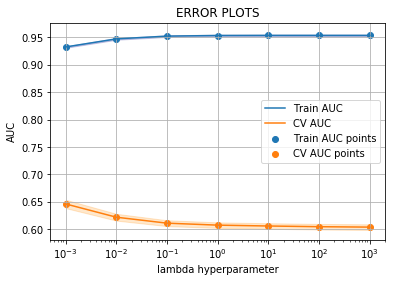

In [104]:
#logistic regression classifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
classifier =  LogisticRegression(penalty ='l2', class_weight= 'balanced', max_iter=200)  #selecting l2 regulerization

#tuned parameters taking lambda1: 'lambda' = 1/cestimator is logistic regression
gridsrch_parameters = [{'C': [10**-3, 10**-2,10**-1, 10**0,10**1,10**2, 10**3]}]
gridsrch_parameters1  = [i  for i in gridsrch_parameters[0]['C']]   #(tuned parameters) : easy to read on x axis

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grdsrch = GridSearchCV(classifier,gridsrch_parameters, scoring = 'roc_auc', cv=5,return_train_score=True)    #estimator is logistic regression
grdsrch.fit(strd_tfidftrain_data, y_train)         #grid search cv applying  on  standerdized train data

train_auc= grdsrch.cv_results_['mean_train_score']
train_auc_std= grdsrch.cv_results_['std_train_score']
cv_auc = grdsrch.cv_results_['mean_test_score'] 
cv_auc_std= grdsrch.cv_results_['std_test_score']

plt.plot(gridsrch_parameters1, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(gridsrch_parameters1,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(gridsrch_parameters1, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(gridsrch_parameters1,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(gridsrch_parameters1, train_auc, label='Train AUC points')
plt.scatter(gridsrch_parameters1, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("lambda hyperparameter")
plt.xscale('log')
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

**observation**
* in above logistic regression we have used l2 regulerization.
* accordung to the above plot train auc and underfit when 'C': lambda value increses
* we can choose best 'C' value as 10*-3  (0.001).

**finding best hyper parameter by using model.best_estimator**

In [106]:
#tuned parameters taking lambda1: 'lambda' = 1/cestimator is logistic regression
gridsrch_parameters = [{'C': [10**-3, 10**-2,10**-1, 10**0,10**1,10**2, 10**3]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty ='l2',class_weight= 'balanced'), gridsrch_parameters, scoring = 'f1', cv=5)
model.fit(strd_tfidftrain_data, y_train)

print(model.best_estimator_)
print(model.score(strd_tfidftest_data, y_test))

LogisticRegression(C=1000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.8059975953037697


**observation**
* best C  value = 0.001 and model f-1 score is 90 percentage 

In [118]:
#according to the above for auc plot result result we can choose 0.001 is our best 'C' as hyper parameter

best_c = 0.001

### Now we can observe how our  best'c' hyper  parameter value perform on Train AUROC and Test AUROC curves

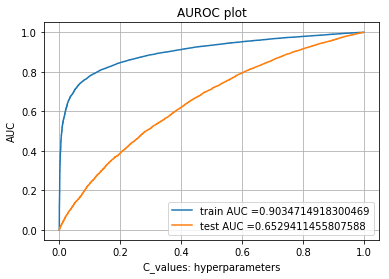

In [119]:
classifier = LogisticRegression(penalty='l2', class_weight= 'balanced',C=best_c)   ## c = 0.001 our selected  best hyper prameter value 
classifier.fit(strd_tfidftrain_data, y_train)   #classifier fit on the tfidf train data
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates  positive class

y_train_pred = batch_predict(classifier,strd_bowtrain_data)    
y_test_pred = batch_predict(classifier, strd_bowtest_data)

#each  thresold (tow) caluculate the (train_fpr = false positive rate) and  (tpr = tru positive rate)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred) #threshoulds on probablity score of train data class label
test_fpr, test_tpr, ts_thresholds = roc_curve(y_test, y_test_pred)#threshoulds on probablity score of test data class label

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))  #plot train auc  based on each threshold train tpr and train fpr
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))  #plot train auc  based on each threshold train tpr and train fpr
plt.xlabel("C_values: hyperparameters")
plt.ylabel("AUC")
plt.title("AUROC plot")
plt.grid()
plt.legend()
plt.show()

### observation:
1. train auc and test auc both are above to the ideal roc curve.
2. AUC(performence metric) on train data = 0.90 and AUC on test data = 0.65


### <font color='purple'>Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
the maximum value of tpr*(1-fpr) 0.6520577107317895 for threshold 0.797
Confusion Matrix:
 [[ 6056  1370]
 [ 8341 33274]]
****************************************
Test data confusion matrix
the maximum value of tpr*(1-fpr) 0.3892837677698266 for threshold 0.878
Confusion Matrix:
 [[ 3511  1948]
 [12076 18517]]


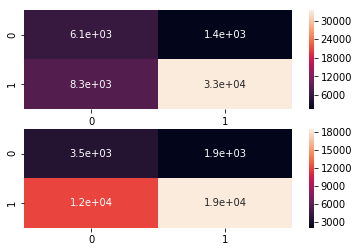

In [109]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

fig=plt.figure(1)
a = fig.add_subplot(211)
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
a = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True)    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test,predict(y_test_pred, ts_thresholds, test_fpr, test_tpr))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True)    #annot = True rectanguler dataset

**observation:**
* in train confusion matrix we have  33274 true positive values, 8341 fpr values, 6056 tnr values,1370 fnr values 
* in test confusion matrix we have  18517 true positive values,12076 fpr values,  3511 tnr values,1948 fnr values 

# 7.Creating (SET3):
# <font color='green'> data matix with all categorical, all numerical,essay(AvgW2V) and title(AvgW2V)</font>

In [110]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#concatinating features
from scipy.sparse import hstack
X_tr3 = hstack((X_train_essay_avgw2v,X_train_title_avgw2v, X_train_state_onehot, X_train_teacher_prefix_onehot, X_train_proj_grade_onehot, X_train_proj_categories_onehot, X_train_proj_subcategories_onehot,X_train_prvs_posted_prjcts_norm, X_train_price_norm,X_train_quantity_norm )).tocsr()
X_cr3 = hstack((X_cv_essay_avgw2v,X_cv_title_avgw2v,   X_cv_state_onehot, X_cv_teacher_prefix_onehot,  X_cv_proj_grade_onehot, X_cv_proj_categories_onehot ,  X_cv_proj_subcategories_onehot,  X_cv_prvs_posted_prjcts_norm , X_cv_price_norm, X_cv_quantity_norm )).tocsr()
X_te3 = hstack((X_test_essay_avgw2v,X_test_title_avgw2v, X_test_state_onehot, X_test_teacher_prefix_onehot,X_test_proj_grade_onehot, X_test_proj_categories_onehot,X_test_proj_subcategories_onehot, X_test_prvs_posted_prjcts_norm, X_test_price_norm,X_test_quantity_norm  )).tocsr()

print("*"*60)
print("Final set3 Data matrix:")
print(X_tr3.shape, y_train.shape)
print(X_cr3.shape, y_cv.shape)
print(X_te3.shape, y_test.shape)

************************************************************
Final set3 Data matrix:
(49041, 203) (49041,)
(24155, 203) (24155,)
(36052, 203) (36052,)


**standardization of train,cv and test data with mean = False**

In [111]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

#standardization train data
strd2 = StandardScaler(with_mean=False)
strd2.fit(X_tr3)

strd_avgw2vftrain_data = strd2.transform(X_tr3)
print(strd_avgw2vftrain_data.shape)
#standardization crosas validationdata
strd_avgw2vcrv_data = strd2.transform(X_cr3)
print(strd_avgw2vcrv_data.shape)
#standardization test data
strd_avgw2vtest_data=strd2.transform(X_te3)
print(strd_avgw2vtest_data.shape)

(49041, 203)
(24155, 203)
(36052, 203)


## <font color='blue'>best parameter tuning using Grid search technique</font>

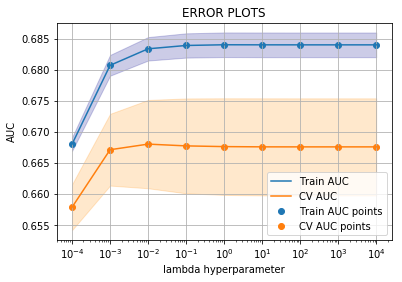

In [112]:

#logistic regression classifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
classifier =  LogisticRegression(penalty ='l2',class_weight= 'balanced', max_iter=100)  #selecting l2 regulerization

#tuned parameters taking lambda1: 'lambda' = 1/cestimator is logistic regression
gridsrch_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 10**0,10**1,10**2, 10**3, 10**4]}]
gridsrch_parameters1  = [i  for i in gridsrch_parameters[0]['C']]   #(tuned parameters) : easy to read on x axis

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grdsrch = GridSearchCV(classifier,gridsrch_parameters, scoring = 'roc_auc', cv=5,return_train_score=True)    #estimator is logistic regression
grdsrch.fit(strd_avgw2vftrain_data, y_train)         #grid search cv applying  on  standerdized train data

train_auc= grdsrch.cv_results_['mean_train_score']
train_auc_std= grdsrch.cv_results_['std_train_score']
cv_auc = grdsrch.cv_results_['mean_test_score'] 
cv_auc_std= grdsrch.cv_results_['std_test_score']

plt.plot(gridsrch_parameters1, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(gridsrch_parameters1,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(gridsrch_parameters1, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(gridsrch_parameters1,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(gridsrch_parameters1, train_auc, label='Train AUC points')
plt.scatter(gridsrch_parameters1, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("lambda hyperparameter")
plt.xscale('log')
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

**observation**
* in above logistic regression we have used l2 regulerization.
* accordung to the above plot train auc and underfit when 'C': lambda value increses
* we can choose best 'C' value as 10

**finding best hyper parameter by using model.best_estimator**

In [113]:

#tuned parameters taking lambda1: 'lambda' = 1/cestimator is logistic regression
gridsrch_parameters = [{'C': [10**-3, 10**-2,10**-1, 10**0,10**1,10**2, 10**3]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty ='l2',class_weight= 'balanced'), gridsrch_parameters, scoring = 'f1', cv=5)
model.fit(strd_avgw2vftrain_data, y_train)

print(model.best_estimator_)
print(model.score(strd_avgw2vtest_data, y_test))

LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.7521770544168537


**observation**
* best C  value = 1 and model f-1 score is 90 percentage 

In [124]:
#according to the above for auc plot result result we can choose 1 is our best 'C' as hyper parameter

best_c = 1

### Now we can observe how our  best'c' hyper  parameter value perform on Train AUROC and Test AUROC curves

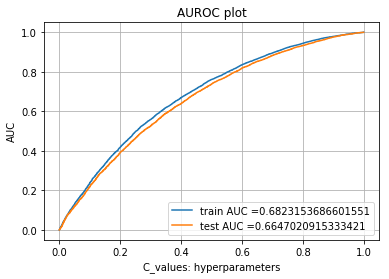

In [125]:
classifier = LogisticRegression(penalty='l2',C=1)   ## c = 1 our selected  best hyper prameter value 
classifier.fit(strd_avgw2vftrain_data , y_train)   #classifier fit on the tfidf train data
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates  positive class

y_train_pred = batch_predict(classifier,strd_avgw2vftrain_data)    
y_test_pred = batch_predict(classifier, strd_avgw2vtest_data)

#each  thresold (tow) caluculate the (train_fpr = false positive rate) and  (tpr = tru positive rate)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred) #threshoulds on probablity score of train data class label
test_fpr, test_tpr, ts_thresholds = roc_curve(y_test, y_test_pred)#threshoulds on probablity score of test data class label

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))  #plot train auc  based on each threshold train tpr and train fpr
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))  #plot train auc  based on each threshold train tpr and train fpr
plt.xlabel("C_values: hyperparameters")
plt.ylabel("AUC")
plt.title("AUROC plot")
plt.grid()
plt.legend()
plt.show()

### observation:
1. train auc and test auc both are above to the ideal roc curve.
2. AUC(performence metric) on train data = 0.68 and AUC on test data = 0.66


### <font color='purple'>Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
the maximum value of tpr*(1-fpr) 0.40306916746979016 for threshold 0.842
Confusion Matrix:
 [[ 4582  2844]
 [14430 27185]]
****************************************
Test data confusion matrix
the maximum value of tpr*(1-fpr) 0.38589221911749216 for threshold 0.853
Confusion Matrix:
 [[ 3374  2085]
 [11492 19101]]


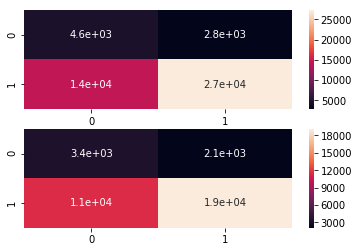

In [126]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

fig=plt.figure(1)
a = fig.add_subplot(211)
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
a = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True)    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test,predict(y_test_pred, ts_thresholds, test_fpr, test_tpr))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True)    #annot = True rectanguler dataset

**observation:**
* in train confusion matrix we have  27185 true positive values, 14430 fpr values, 4582 tnr values,2844 fnr values 
* in test confusion matrix we have  19101 true positive values,11492 fpr values,  3374 tnr values,2085 fnr values 

# 8.Creating (SET4):
# <font color='green'> data matix with all categorical, all numerical,essay(TFIDF-W2V) and title(TFIDF-W2V)</font>

In [127]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#concatinating features
from scipy.sparse import hstack
X_tr4 = hstack((X_train_essay_tfidfw2v,X_train_title_tfidfw2v, X_train_state_onehot, X_train_teacher_prefix_onehot, X_train_proj_grade_onehot, X_train_proj_categories_onehot, X_train_proj_subcategories_onehot,X_train_prvs_posted_prjcts_norm, X_train_price_norm,X_train_quantity_norm )).tocsr()
X_cr4 = hstack((X_cv_essay_tfidfw2v,X_cv_title_tfidfw2v,   X_cv_state_onehot, X_cv_teacher_prefix_onehot,  X_cv_proj_grade_onehot, X_cv_proj_categories_onehot ,  X_cv_proj_subcategories_onehot,  X_cv_prvs_posted_prjcts_norm , X_cv_price_norm, X_cv_quantity_norm )).tocsr()
X_te4 = hstack((X_test_essay_tfidfw2v,X_test_title_tfidfw2v, X_test_state_onehot, X_test_teacher_prefix_onehot,X_test_proj_grade_onehot, X_test_proj_categories_onehot,X_test_proj_subcategories_onehot, X_test_prvs_posted_prjcts_norm, X_test_price_norm,X_test_quantity_norm  )).tocsr()

print("*"*60)
print("Final set4 Data matrix:")
print(X_tr4.shape, y_train.shape)
print(X_cr4.shape, y_cv.shape)
print(X_te4.shape, y_test.shape)


************************************************************
Final set4 Data matrix:
(49041, 203) (49041,)
(24155, 203) (24155,)
(36052, 203) (36052,)


**standardization of train,cv and test data with mean = False**

In [128]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

#standardization train data
strd3 = StandardScaler(with_mean=False)
strd3.fit(X_tr4)

strd_tfidfw2vtrain_data = strd3.transform(X_tr4)
print(strd_tfidfw2vtrain_data.shape)
#standardization crosas validationdata
strd_tfidfw2vcrv_data = strd3.transform(X_cr4)
print(strd_tfidfw2vcrv_data.shape)
#standardization test data
strd_tfidfw2vtest_data=strd3.transform(X_te4)
print(strd_tfidfw2vtest_data.shape)

(49041, 203)
(24155, 203)
(36052, 203)


## <font color='blue'>best parameter tuning using Grid search technique</font>

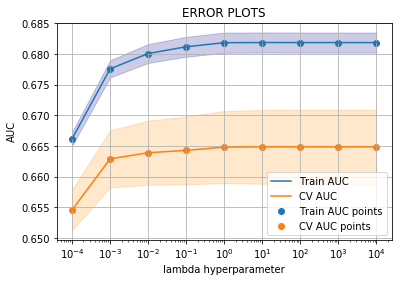

In [129]:
#logistic regression classifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
classifier =  LogisticRegression(penalty ='l2',class_weight= 'balanced', max_iter=100)  #selecting l2 regulerization

#tuned parameters taking lambda1: 'lambda' = 1/cestimator is logistic regression
gridsrch_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 10**0,10**1,10**2, 10**3, 10**4]}]
gridsrch_parameters1  = [i  for i in gridsrch_parameters[0]['C']]   #(tuned parameters) : easy to read on x axis

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grdsrch = GridSearchCV(classifier,gridsrch_parameters, scoring = 'roc_auc', cv=5,return_train_score=True)    #estimator is logistic regression
grdsrch.fit(strd_tfidfw2vtrain_data, y_train)         #grid search cv applying  on  standerdized train data

train_auc= grdsrch.cv_results_['mean_train_score']
train_auc_std= grdsrch.cv_results_['std_train_score']
cv_auc = grdsrch.cv_results_['mean_test_score'] 
cv_auc_std= grdsrch.cv_results_['std_test_score']

plt.plot(gridsrch_parameters1, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(gridsrch_parameters1,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(gridsrch_parameters1, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(gridsrch_parameters1,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(gridsrch_parameters1, train_auc, label='Train AUC points')
plt.scatter(gridsrch_parameters1, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("lambda hyperparameter")
plt.xscale('log')
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

**observation**
* in above logistic regression we have used l2 regulerization.
* accordung to the above plot train auc and underfit when 'C': lambda value increses
* we can choose best 'C' value as 10*-3  (0.001).

**finding best hyper parameter by using model.best_estimator**


In [130]:
#tuned parameters taking lambda1: 'lambda' = 1/cestimator is logistic regression
gridsrch_parameters = [{'C': [10**-3, 10**-2,10**-1, 10**0,10**1,10**2, 10**3]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty ='l2',class_weight= 'balanced'),gridsrch_parameters,scoring = 'f1', cv=5)
model.fit(strd_tfidfw2vtrain_data, y_train)

print(model.best_estimator_)
print(model.score(strd_tfidfw2vtest_data, y_test))

LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.7329914131406147


**observation**
* best C  value = 0.001 and model f-1 score is 91 percentage 

In [132]:
#according to the above for auc plot result result we can choose 0.001 is our best 'C' as hyper parameter

best_c = 0.001

### Now we can observe how our  best'c' hyper  parameter value perform on Train AUROC and Test AUROC curves

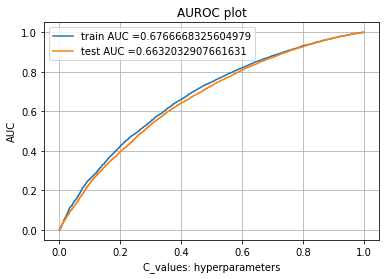

In [141]:
classifier = LogisticRegression(penalty='l2',class_weight= 'balanced',C=best_c)   ## c = 0.001 our selected  best hyper prameter value 
classifier.fit(strd_tfidfw2vtrain_data , y_train)   #classifier fit on the tfidf train data
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates  positive class

y_train_pred = batch_predict(classifier,strd_tfidfw2vtrain_data)    
y_test_pred = batch_predict(classifier, strd_tfidfw2vtest_data)

#each  thresold (tow) caluculate the (train_fpr = false positive rate) and  (tpr = tru positive rate)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred) #threshoulds on probablity score of train data class label
test_fpr, test_tpr, ts_thresholds = roc_curve(y_test, y_test_pred)#threshoulds on probablity score of test data class label

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))  #plot train auc  based on each threshold train tpr and train fpr
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))  #plot train auc  based on each threshold train tpr and train fpr
plt.xlabel("C_values: hyperparameters")
plt.ylabel("AUC")
plt.title("AUROC plot")
plt.grid()
plt.legend()
plt.show()

### observation:
1. train auc and test auc both are above to the ideal roc curve.
2. AUC(performence metric) on train data = 0.67 and AUC on test data = 0.66


### <font color='purple'>Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
the maximum value of tpr*(1-fpr) 0.393191176773716 for threshold 0.839
Confusion Matrix:
 [[ 4473  2953]
 [14450 27165]]
****************************************
Test data confusion matrix
the maximum value of tpr*(1-fpr) 0.38222661639106587 for threshold 0.848
Confusion Matrix:
 [[ 3464  1995]
 [12165 18428]]


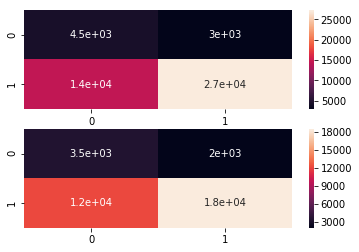

In [134]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

fig=plt.figure(1)
a = fig.add_subplot(211)
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
a = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True)    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test,predict(y_test_pred, ts_thresholds, test_fpr, test_tpr))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True)    #annot = True rectanguler dataset

**observation:**
* in train confusion matrix we have  27165 true positive values,14450 fpr values, 4473  tnr values,2953 fnr values 
* in test confusion matrix we have  18428 true positive values,12165 fpr values,  3464 tnr values, 1995 fnr values 

# 8.Creating (SET5):
# <font color='green'> data matix with all categorical, all numerical</font>

In [135]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#concatinating features
from scipy.sparse import hstack
X_tr5 = hstack(( X_train_state_onehot, X_train_teacher_prefix_onehot, X_train_proj_grade_onehot, X_train_proj_categories_onehot, X_train_proj_subcategories_onehot,X_train_prvs_posted_prjcts_norm, X_train_price_norm,X_train_quantity_norm )).tocsr()
X_cr5 = hstack((  X_cv_state_onehot, X_cv_teacher_prefix_onehot,  X_cv_proj_grade_onehot, X_cv_proj_categories_onehot ,  X_cv_proj_subcategories_onehot,  X_cv_prvs_posted_prjcts_norm , X_cv_price_norm, X_cv_quantity_norm )).tocsr()
X_te5 = hstack(( X_test_state_onehot, X_test_teacher_prefix_onehot,X_test_proj_grade_onehot, X_test_proj_categories_onehot,X_test_proj_subcategories_onehot, X_test_prvs_posted_prjcts_norm, X_test_price_norm,X_test_quantity_norm  )).tocsr()

print("*"*60)
print("Final set4 Data matrix:")
print(X_tr5.shape, y_train.shape)
print(X_cr5.shape, y_cv.shape)
print(X_te5.shape, y_test.shape)


************************************************************
Final set4 Data matrix:
(49041, 103) (49041,)
(24155, 103) (24155,)
(36052, 103) (36052,)


**standardization of train,cv and test data with mean = False**

In [136]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

#standardization train data
strd4 = StandardScaler(with_mean=False)
strd4.fit(X_tr5)

strd_train_data = strd4.transform(X_tr5)
print(strd_train_data.shape)
#standardization crosas validationdata
strd_crv_data = strd4.transform(X_cr5)
print(strd_crv_data.shape)
#standardization test data
strd_test_data=strd4.transform(X_te5)
print(strd_test_data.shape)

(49041, 103)
(24155, 103)
(36052, 103)


## <font color='blue'>best parameter tuning using Grid search technique</font>

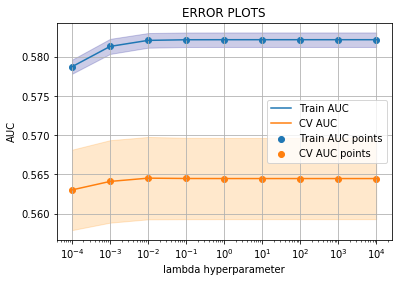

In [137]:

#logistic regression classifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
classifier =  LogisticRegression(penalty ='l2',class_weight= 'balanced', max_iter=100)  #selecting l2 regulerization

#tuned parameters taking lambda1: 'lambda' = 1/cestimator is logistic regression
gridsrch_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 10**0,10**1,10**2, 10**3, 10**4]}]
gridsrch_parameters1  = [i  for i in gridsrch_parameters[0]['C']]   #(tuned parameters) : easy to read on x axis

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grdsrch = GridSearchCV(classifier,gridsrch_parameters, scoring = 'roc_auc', cv=5,return_train_score=True)    #estimator is logistic regression
grdsrch.fit(strd_train_data, y_train)         #grid search cv applying  on  standerdized train data

train_auc= grdsrch.cv_results_['mean_train_score']
train_auc_std= grdsrch.cv_results_['std_train_score']
cv_auc = grdsrch.cv_results_['mean_test_score'] 
cv_auc_std= grdsrch.cv_results_['std_test_score']

plt.plot(gridsrch_parameters1, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(gridsrch_parameters1,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(gridsrch_parameters1, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(gridsrch_parameters1,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(gridsrch_parameters1, train_auc, label='Train AUC points')
plt.scatter(gridsrch_parameters1, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("lambda hyperparameter")
plt.xscale('log')
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

**observation**
* in above logistic regression we have used l2 regulerization.
* accordung to the above plot train auc and underfit when 'C': lambda value increses
* we can choose best 'C' value as 10*-3  (0.001).

**finding best hyper parameter by using model.best_estimator**

In [138]:
#tuned parameters taking lambda1: 'lambda' = 1/cestimator is logistic regression
gridsrch_parameters = [{'C': [10**-3, 10**-2,10**-1, 10**0,10**1,10**2, 10**3]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty ='l2',class_weight= 'balanced'),gridsrch_parameters,scoring = 'f1', cv=5)
model.fit(strd_train_data, y_train)

print(model.best_estimator_)
print(model.score(strd_test_data, y_test))

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.6757946993354151


In [139]:
#according to the above for auc plot result result we can choose 0.001 is our best 'C' as hyper parameter

best_c = 0.001

### Now we can observe how our  best'c' hyper  parameter value perform on Train AUROC and Test AUROC curves

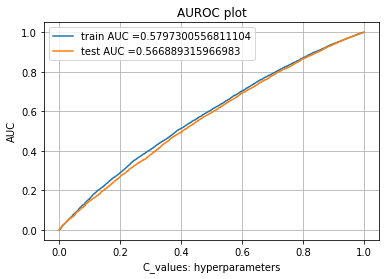

In [140]:
classifier = LogisticRegression(penalty='l2',class_weight= 'balanced',C=best_c)   ## c =  our selected  best hyper prameter value 
classifier.fit(strd_train_data , y_train)   #classifier fit on the tfidf train data
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates  positive class

y_train_pred = batch_predict(classifier,strd_train_data)    
y_test_pred = batch_predict(classifier, strd_test_data)

#each  thresold (tow) caluculate the (train_fpr = false positive rate) and  (tpr = tru positive rate)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred) #threshoulds on probablity score of train data class label
test_fpr, test_tpr, ts_thresholds = roc_curve(y_test, y_test_pred)#threshoulds on probablity score of test data class label

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))  #plot train auc  based on each threshold train tpr and train fpr
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))  #plot train auc  based on each threshold train tpr and train fpr
plt.xlabel("C_values: hyperparameters")
plt.ylabel("AUC")
plt.title("AUROC plot")
plt.grid()
plt.legend()
plt.show()

### observation:
1. train auc and test auc both are above to the ideal roc curve.
2. AUC(performence metric) on train data = 0.57 and AUC on test data = 0.56


### <font color='purple'>Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
the maximum value of tpr*(1-fpr) 0.3986607869923532 for threshold 0.493
Confusion Matrix:
 [[ 4645  2781]
 [15092 26523]]
****************************************
Test data confusion matrix
the maximum value of tpr*(1-fpr) 0.3869318510226748 for threshold 0.501
Confusion Matrix:
 [[ 3440  2019]
 [11808 18785]]


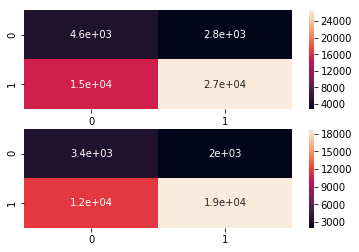

In [142]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

fig=plt.figure(1)
a = fig.add_subplot(211)
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
a = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True)    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test,predict(y_test_pred, ts_thresholds, test_fpr, test_tpr))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True)    #annot = True rectanguler dataset

**observation:**
* in train confusion matrix we have  26523 true positive values,15092 fpr values, 4645  tnr values,2781 fnr values 
* in test confusion matrix we have  18785 true positive values,11808 fpr values,  3440 tnr values, 2019 fnr values 

# Summary(Conclusion):
* we have selected logistic regression classifier  with penality = l2 regulerization   
* we have find best 'C'(lambda=1/C) hyper parameter by using grid search method logistic regression classifier for 5 sets data.
* we can  observe all AUROC values on plots for each set(se1...set5) then we can choose best 'C' value  on set1 which consists train auc is 0.91 test auc 0.62  then we can select best hyper'C' parameter value is 1.
* cofusion matrix  gives us clear details about how many true positive points and false positive points,true negetive points and false negetive points for each set data.

# Summary in Tabular form
### all results summarized in the tabular form

In [146]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
a = PrettyTable()
a.field_names = ["data with vectorized features","Model","Hyper_parameter_best_alpha value", "AUC"]

a.add_row(["set1(all numrcal,ctgrc+essay&tite(BOW))", "LR(grd_serach)",1,0.91 ])
a.add_row(["set2(all numrcal,ctgrc+essay&tite(TFIDF)", "LR(grd_serach)",0.001,0.90])
a.add_row(["set3(all numrcal,ctgrc+essay&tite(avgw2v))", "LR(grd_serach)",1,0.68 ])
a.add_row(["set4(all numrcal,ctgrc+essay&tite(tfidfw2v))", "LR(grd_serach)",0.001,0.67 ])
a.add_row(["set5(all numerical& allcategoric", "LR(grd_serach)",0.001,0.57 ])
print(a)

+----------------------------------------------+----------------+----------------------------------+------+
|        data with vectorized features         |     Model      | Hyper_parameter_best_alpha value | AUC  |
+----------------------------------------------+----------------+----------------------------------+------+
|   set1(all numrcal,ctgrc+essay&tite(BOW))    | LR(grd_serach) |                1                 | 0.91 |
|   set2(all numrcal,ctgrc+essay&tite(TFIDF)   | LR(grd_serach) |              0.001               | 0.9  |
|  set3(all numrcal,ctgrc+essay&tite(avgw2v))  | LR(grd_serach) |                1                 | 0.68 |
| set4(all numrcal,ctgrc+essay&tite(tfidfw2v)) | LR(grd_serach) |              0.001               | 0.67 |
|       set5(all numerical& allcategoric       | LR(grd_serach) |              0.001               | 0.57 |
+----------------------------------------------+----------------+----------------------------------+------+
